In [53]:
%matplotlib inline

import os
import torch
import random
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.manifold import TSNE
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.explain import Explainer, GNNExplainer

# Data preparation

A loader class to load a previously saved dataset onto memory for CPU learning.

In [20]:
class CoraDataset(InMemoryDataset):
    def __init__(self, root):
        super().__init__(root,
                         transform=None,
                         pre_transform=None,
                         pre_filter=None)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        return [
            "ind.cora.allx"
            "ind.cora.ally"
            "ind.cora.graph"
            "ind.cora.test.index"
            "ind.cora.tx"
            "ind.cora.ty"
            "ind.cora.x"
            "ind.cora.y"
        ]
        
    @property
    def processed_file_names(self):
        return ["data.pt", "pre_filter.pt", "pre_transform.pt"]

Load the dataset.

In [21]:
data_root = Path(os.environ["FLAKE_ROOT"], "data", "Cora")
dataset = CoraDataset(root=data_root)
data = dataset[0]

# Transductive node classification with MLP

Define an MLP model.

In [22]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Train an MLP model for node classification.

In [37]:
# sometimes really dont understand torch ffs
import torch.nn.functional as F


model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9589
Epoch: 002, Loss: 1.9115
Epoch: 003, Loss: 1.8296
Epoch: 004, Loss: 1.7399
Epoch: 005, Loss: 1.6110
Epoch: 006, Loss: 1.5677
Epoch: 007, Loss: 1.4014
Epoch: 008, Loss: 1.3110
Epoch: 009, Loss: 1.2361
Epoch: 010, Loss: 1.1290
Epoch: 011, Loss: 1.0854
Epoch: 012, Loss: 0.9861
Epoch: 013, Loss: 0.8618
Epoch: 014, Loss: 0.8257
Epoch: 015, Loss: 0.6789
Epoch: 016, Loss: 0.7199
Epoch: 017, Loss: 0.6508
Epoch: 018, Loss: 0.6374
Epoch: 019, Loss: 0.5672
Epoch: 020, Loss: 0.4760
Epoch: 021, Loss: 0.4683
Epoch: 022, Loss: 0.4964
Epoch: 023, Loss: 0.4768
Epoch: 024, Loss: 0.4000
Epoch: 025, Loss: 0.4318
Epoch: 026, Loss: 0.4132
Epoch: 027, Loss: 0.3652
Epoch: 028, Loss: 0.3459
Epoch: 029, Loss: 0.3336
Epoch: 030, Loss: 0.2924
Epoch: 031, Loss: 0.3015
Epoch: 032, Loss: 0.3098
Epoch: 033, Loss: 0.2611
Epoch: 034, Loss: 0.3010
Epoch: 035, Loss: 0.3030
Epoch: 036, Loss: 0.2753
Epoch: 037, Loss: 0.2880
Epoch: 038, Loss: 0.2475
Epoch: 039, Loss: 0.3480
Epoch: 040, Loss: 0.2840


Evaluate the accuracy of the trained model.

In [38]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5660


# Transductive node classification with GCN

Define a GCN model

In [39]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Pretty plot

In [46]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Node embedding of an untrained GNN

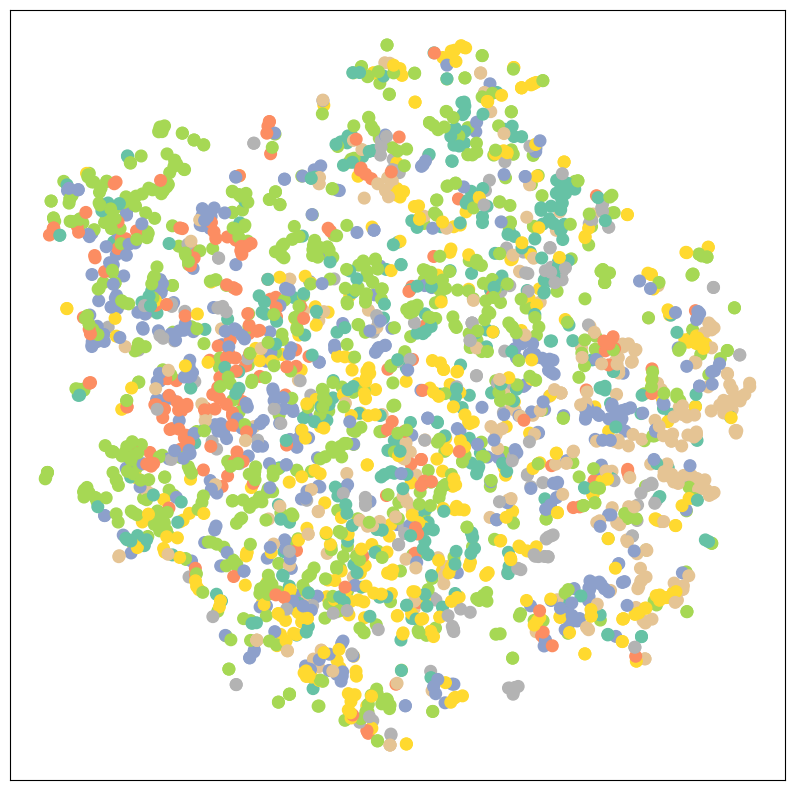

In [47]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [49]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9523
Epoch: 002, Loss: 1.8623
Epoch: 003, Loss: 1.7444
Epoch: 004, Loss: 1.6160
Epoch: 005, Loss: 1.4674
Epoch: 006, Loss: 1.3654
Epoch: 007, Loss: 1.2469
Epoch: 008, Loss: 1.1128
Epoch: 009, Loss: 0.9917
Epoch: 010, Loss: 0.8651
Epoch: 011, Loss: 0.7830
Epoch: 012, Loss: 0.7212
Epoch: 013, Loss: 0.6193
Epoch: 014, Loss: 0.5478
Epoch: 015, Loss: 0.5029
Epoch: 016, Loss: 0.4430
Epoch: 017, Loss: 0.3946
Epoch: 018, Loss: 0.3410
Epoch: 019, Loss: 0.3056
Epoch: 020, Loss: 0.2745
Epoch: 021, Loss: 0.2727
Epoch: 022, Loss: 0.2354
Epoch: 023, Loss: 0.2047
Epoch: 024, Loss: 0.1939
Epoch: 025, Loss: 0.1491
Epoch: 026, Loss: 0.1828
Epoch: 027, Loss: 0.1721
Epoch: 028, Loss: 0.1270
Epoch: 029, Loss: 0.1265
Epoch: 030, Loss: 0.1228
Epoch: 031, Loss: 0.1113
Epoch: 032, Loss: 0.0913
Epoch: 033, Loss: 0.0993
Epoch: 034, Loss: 0.1178
Epoch: 035, Loss: 0.0816
Epoch: 036, Loss: 0.0915
Epoch: 037, Loss: 0.0968
Epoch: 038, Loss: 0.0722
Epoch: 039, Loss: 0.0550
Epoch: 040, Loss: 0.0717


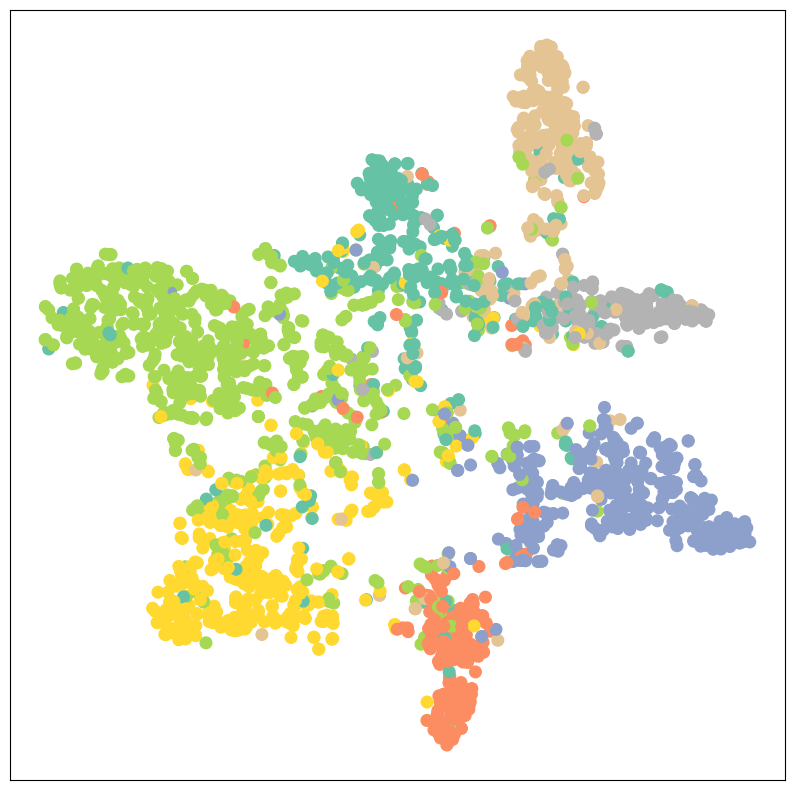

In [50]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [54]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

In [55]:
node_index = 10
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

Generated explanations in ['edge_mask', 'node_mask']


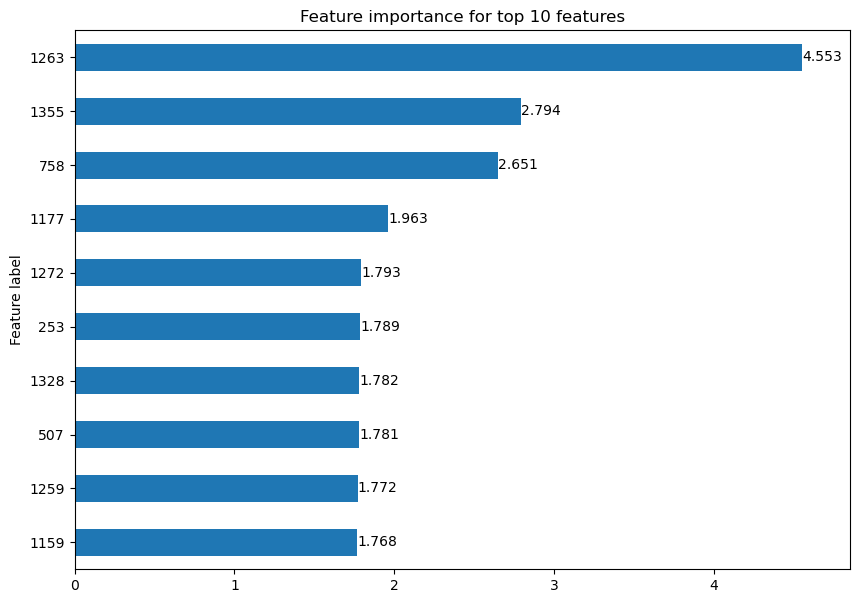

In [57]:
explanation.visualize_feature_importance(top_k=10)

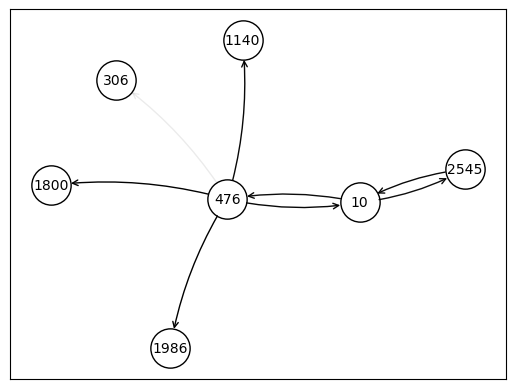

In [58]:
explanation.visualize_graph()

In [64]:
explanation.validate()

True